In [2]:
import sys
import time
import math
import torch
import random
import warnings
import numpy as np
from phe import paillier
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.neighbors import BallTree, NearestNeighbors

from const import *
from data import get_dataloader

warnings.filterwarnings('ignore')

In [3]:
init_seed = 0
torch.manual_seed(init_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(init_seed)
np.random.seed(init_seed)
random.seed(init_seed)

# semantic encoding

In [4]:
test_dl = get_dataloader(os.path.join(data_dir, "triplet_both_test_5k.txt"), data_type="eval", batch_size=64)
# 地址语义编码器
semantic_encoder_path = os.path.join(
    model_dir, "2022-06-03/Federated/Transformer+GE-type+Entity-Pooler/Sup-SimCSE/21:17:10-Federated_Transformer+GE-type+Entity-Pooler_Sup-SimCSE-global.pt")
semantic_encoder = torch.load(semantic_encoder_path).to(device)

# alice, bob两方语义向量编码，归一化
alice_representation_database = None
bob_representation_database = None
semantic_encoder.eval()
with torch.no_grad():
    for batch_idx, source in enumerate(test_dl, start=1):
        real_batch_num = source.get('input_ids').shape[0]
        input_ids = source.get('input_ids').view(real_batch_num * 3, -1).to(device)
        attention_mask = source.get('attention_mask').view(real_batch_num * 3, -1).to(device)
        token_type_ids = source.get('token_type_ids').view(real_batch_num * 3, -1).to(device)
        out = semantic_encoder(input_ids, attention_mask, token_type_ids)
        idx = torch.arange(out.shape[0], device=device).unsqueeze(1)
        # 三元组 (anchor, positive, negetive)
        anchor = F.normalize(out.index_select(0, torch.where(idx % 3 == 0)[0]), p=2, dim=1).cpu().numpy()
        positive = F.normalize(out.index_select(0, torch.where(idx % 3 == 1)[0]), p=2, dim=1).cpu().numpy()
        negative = F.normalize(out.index_select(0, torch.where(idx % 3 == 2)[0]), p=2, dim=1).cpu().numpy()
        if batch_idx == 1:
            alice_representation_database = anchor
            bob_representation_database = np.concatenate((positive, negative), axis=0)
        else:
            alice_representation_database = np.concatenate((alice_representation_database, anchor), axis=0)
            bob_representation_database = np.concatenate((bob_representation_database, positive, negative), axis=0)
print(f"alice_representation_database.shape = {alice_representation_database.shape}")
print(f"bob_representation_database.shape = {bob_representation_database.shape}")

5000it [00:00, 274133.93it/s]


alice_representation_database.shape = (5000, 256)
bob_representation_database.shape = (10000, 256)


# Paillier-based secure scalar prodoct protocol

In [5]:
def encrypt_tensor(tensor, public_key):
    encrypted_zero = public_key.encrypt(0)
    if isinstance(tensor, np.ndarray):
        return np.vectorize(lambda e: encrypted_zero + e)(tensor)
    else:
        raise NotImplementedError(f"type={type(tensor)}")

def decrypt_tensor(tensor, private_key, otypes):
    if isinstance(tensor, np.ndarray):
        return np.vectorize(private_key.decrypt, otypes)(tensor)
    else:
        raise NotImplementedError(f"type={type(tensor)}")

public_key, private_key = paillier.generate_paillier_keypair()
x = np.random.rand(1, 256).astype(object)
y = np.random.rand(5, 256).astype(object)
x_enc = encrypt_tensor(x, public_key)
sim_enc = np.dot(y, x_enc.T)
sim_dec = decrypt_tensor(sim_enc, private_key, [object])
sim = np.dot(y, x.T)
print(f"sim_dec = {sim_dec}")
print(f"sim = {sim}")
assert np.allclose(sim_dec.astype(np.float), sim.astype(np.float))

sim_dec = [[63.56897884481502]
 [62.938361236914474]
 [62.20091806481394]
 [61.78412343104636]
 [65.6911078175461]]
sim = [[63.568978844815014]
 [62.9383612369145]
 [62.20091806481393]
 [61.78412343104638]
 [65.69110781754614]]


# Performance analysis

In [6]:
# Alice generate paillier keypair
public_key, private_key = paillier.generate_paillier_keypair()
# Bob construct ball tree
ball_tree_bob = BallTree(bob_representation_database)
# scope of noise \varepsilon
varepsilon = 0.1

# test threshold
start_threshold, end_threshold, step = 0.5, 1.0, 0.05

## Communication traffic

In [7]:
def encrypt_tensor(tensor, public_key):
    encrypted_zero = public_key.encrypt(0)
    if isinstance(tensor, np.ndarray):
        return np.vectorize(lambda e: encrypted_zero + e)(tensor)
    else:
        raise NotImplementedError(f"type={type(tensor)}")

def decrypt_tensor(tensor, private_key, otypes):
    if isinstance(tensor, np.ndarray):
        return np.vectorize(private_key.decrypt, otypes)(tensor)
    else:
        raise NotImplementedError(f"type={type(tensor)}")

In [8]:
num_enc_size = sys.getsizeof(public_key.encrypt(np.random.random_sample()))
num_enc_size

48

In [9]:
num_size = sys.getsizeof(random.random())
num_size

24

In [10]:
def encrypt_tensor(tensor, public_key):
    return tensor

def decrypt_tensor(tensor, private_key, otypes):
    return tensor

In [11]:
D_s = alice_representation_database.shape[0]
D_r = bob_representation_database.shape[0]
d = alice_representation_database.shape[1]

### brute force

In [12]:
# |D_s| * vector_enc_size + |D_s| * |D_r| * sim_enc_size
brute_force_communication_traffic = D_s * d * num_enc_size + D_s * D_r * num_enc_size
brute_force_communication_traffic

2461440000

### Ball tree

In [13]:
ball_tree_communication_traffic = []
for cs_threshold in np.arange(start_threshold, end_threshold, step):
    cs_threshold = round(cs_threshold, 2)
    # matched pairs
    matches_ball_tree = []
    communication_traffic = 0
    for idx_a, query in enumerate(alice_representation_database):
        query = query.reshape(1, -1)
        # Alice: encrypt query vector and generate query ball
        query_enc = encrypt_tensor(query, public_key)
        noise = np.random.rand(*query.shape)
        rand_r = np.random.random_sample() * varepsilon
        noise = normalize(noise) * rand_r
        query_ball_c, query_ball_r = query + noise, 2 - 2 * cs_threshold + rand_r
        assert math.isclose(np.linalg.norm(query_ball_c-query), rand_r)
        # Alice  ---query_enc, query_ball_c, query_ball_r---> Bob
        communication_traffic += d * num_enc_size
        communication_traffic += d * num_size + num_size

        # Bob: query ball in ball tree
        inds_ball_tree = ball_tree_bob.query_radius(query_ball_c, query_ball_r)
        inds_ball_tree = inds_ball_tree[0]
        if inds_ball_tree.size > 0:
            candidates_ball_tree = bob_representation_database[inds_ball_tree]
            # Bob: compute encryted similarities
            simsEnc_ball_tree = np.dot(candidates_ball_tree, query_enc.T)
            # Bob  ---encrypted similarities---> Alice
            communication_traffic += inds_ball_tree.size * num_enc_size
            
            # Alice: decrypte similarities
            simsDec_ball_tree = decrypt_tensor(simsEnc_ball_tree, private_key, [object])
            # Alice: select match pairs
            argmax_ball_tree = simsDec_ball_tree.argmax()
            simMax_ball_tree = simsDec_ball_tree[argmax_ball_tree]
            if simMax_ball_tree >= cs_threshold:
                indMax_ball_tree = inds_ball_tree[argmax_ball_tree]
                matches_ball_tree.append((idx_a, indMax_ball_tree))
    ball_tree_communication_traffic.append(communication_traffic)
    print(f"cs_threshold {cs_threshold}: communication_traffic = {communication_traffic}")

cs_threshold 0.5: communication_traffic = 97685424
cs_threshold 0.55: communication_traffic = 93649728
cs_threshold 0.6: communication_traffic = 92769984
cs_threshold 0.65: communication_traffic = 92571888
cs_threshold 0.7: communication_traffic = 92519184
cs_threshold 0.75: communication_traffic = 92489328
cs_threshold 0.8: communication_traffic = 92460768
cs_threshold 0.85: communication_traffic = 92426592
cs_threshold 0.9: communication_traffic = 92388240
cs_threshold 0.95: communication_traffic = 92322816


In [14]:
ball_tree_communication_traffic

[97685424,
 93649728,
 92769984,
 92571888,
 92519184,
 92489328,
 92460768,
 92426592,
 92388240,
 92322816]

In [15]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm
%matplotlib inline

In [16]:
relative_communication_traffic = brute_force_communication_traffic / np.array(ball_tree_communication_traffic)
relative_communication_traffic

array([25.19761802, 26.28347196, 26.53271989, 26.58949767, 26.6046445 ,
       26.61323261, 26.62145311, 26.63129676, 26.64235188, 26.66123182])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


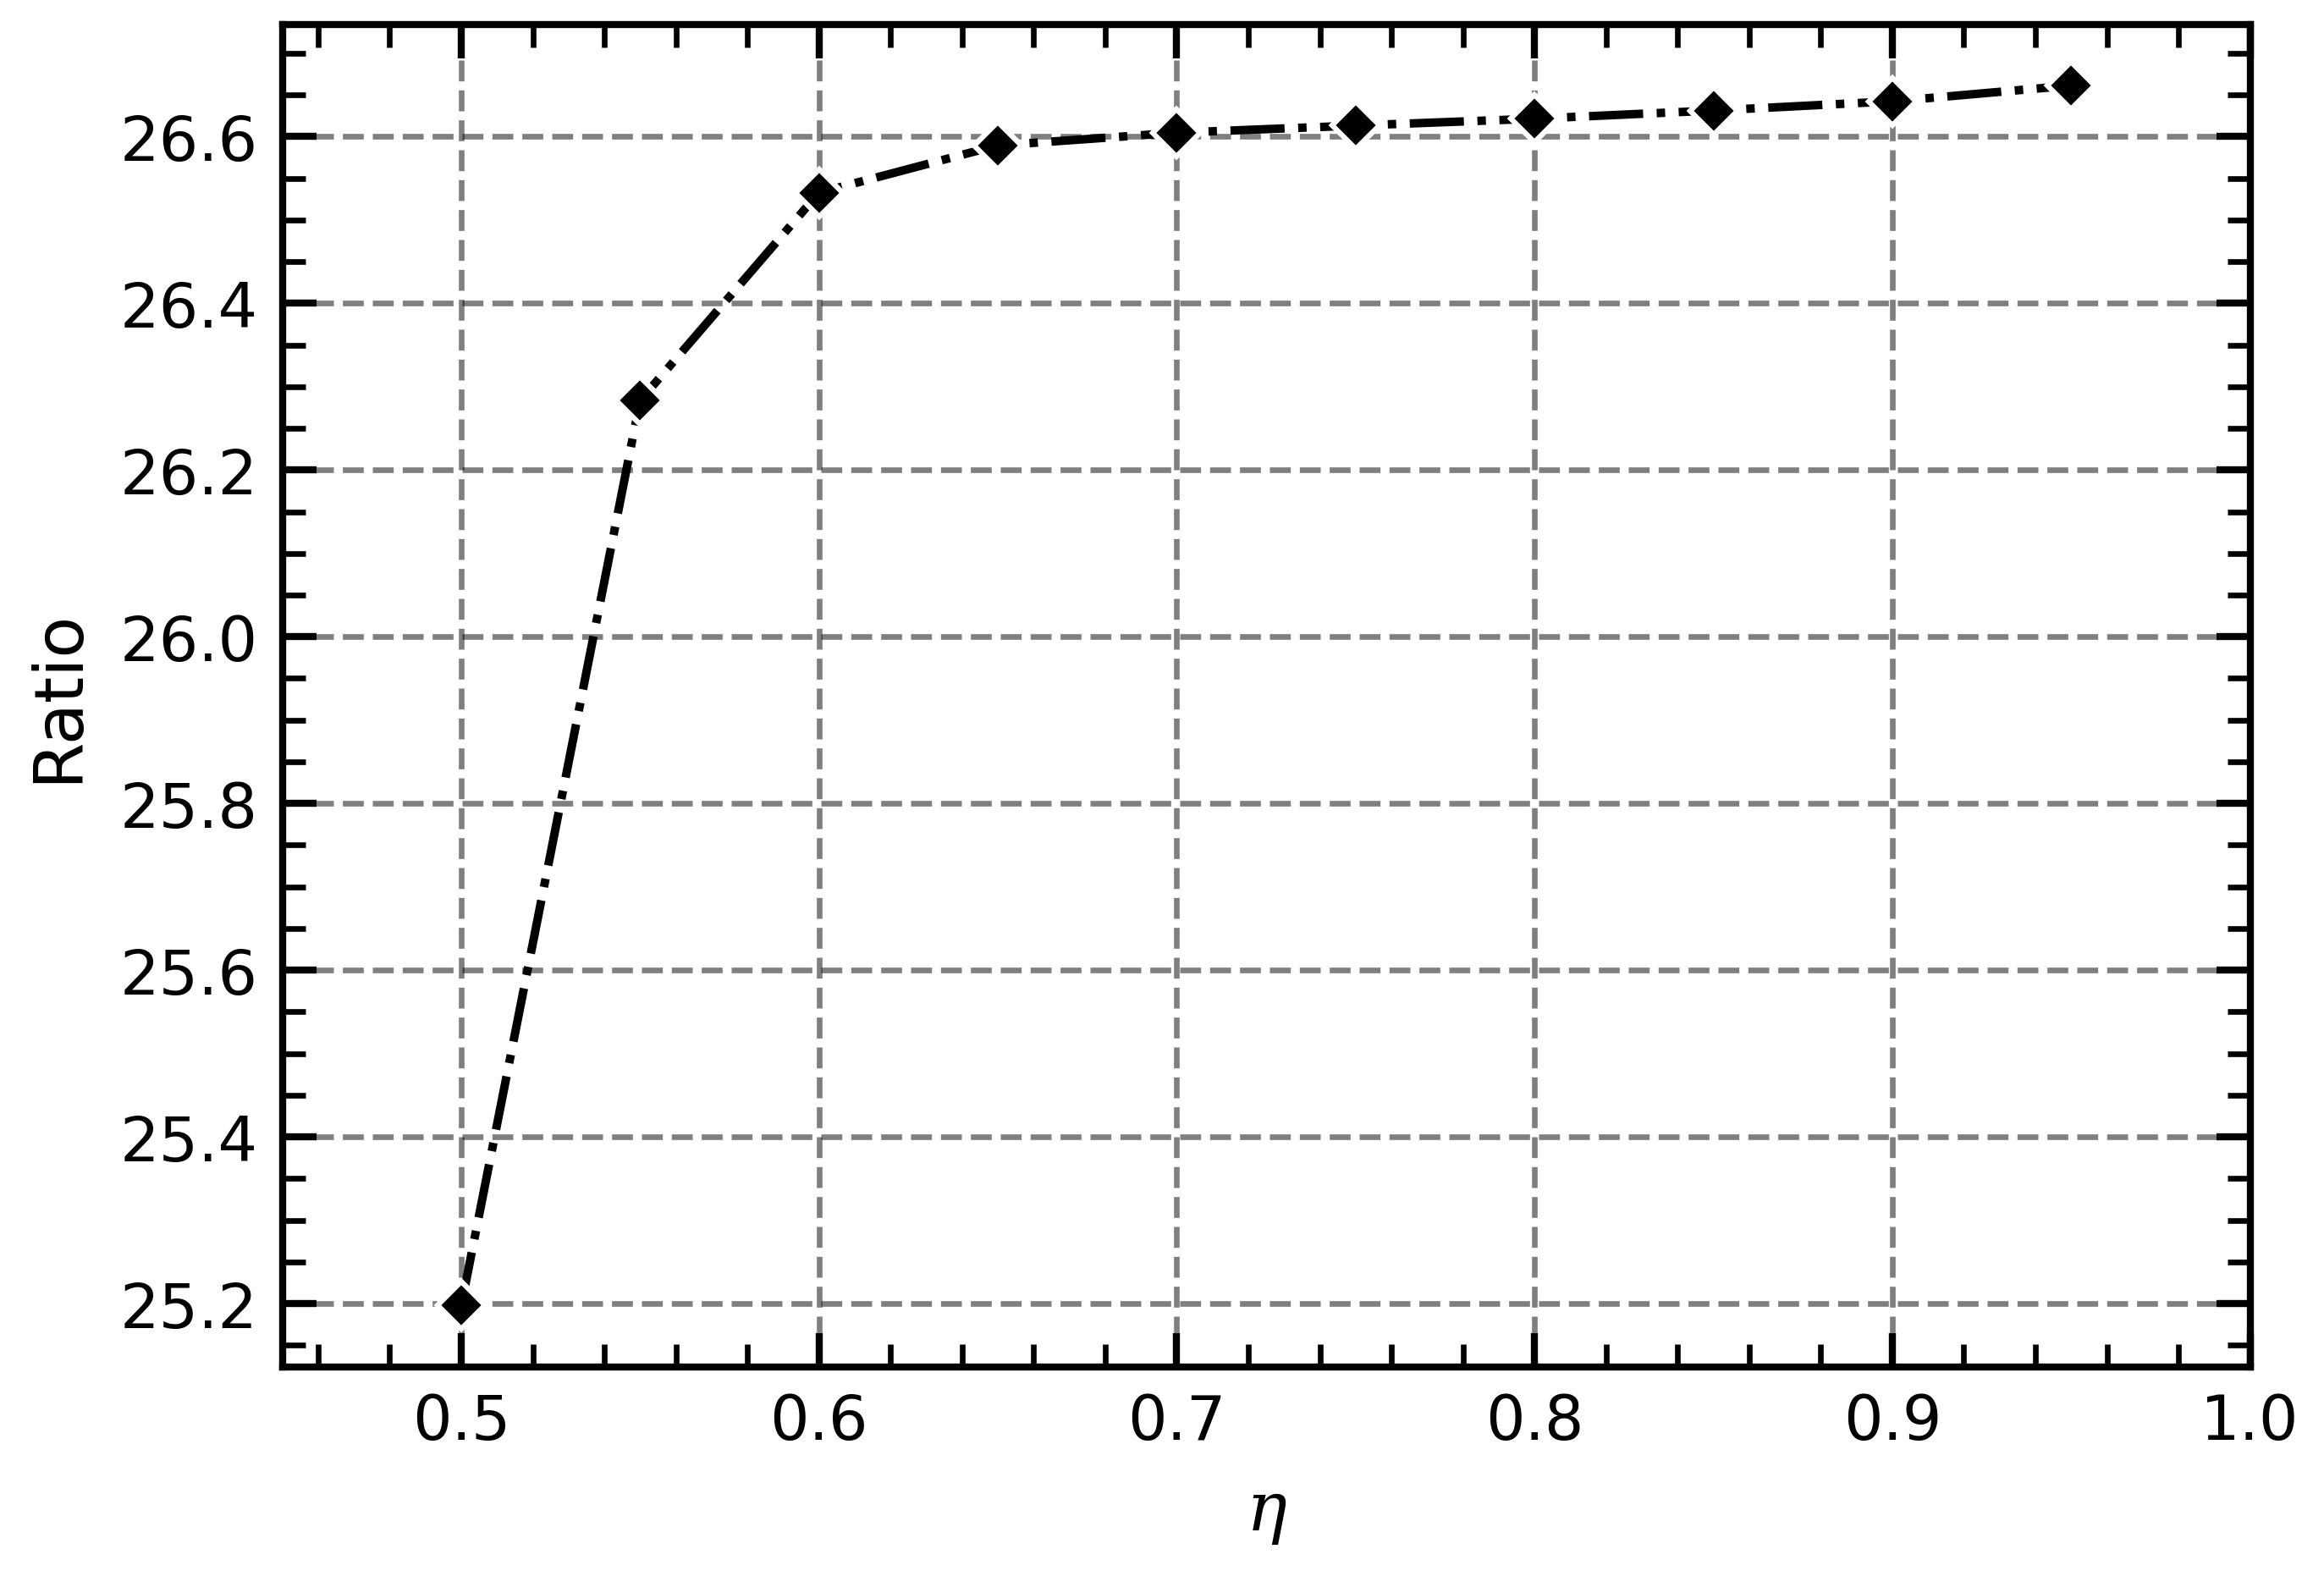

In [30]:
# plt.style.use(['science', 'ieee', 'no-latex'])
# # sns.set(style="whitegrid", color_codes=True)
# # sns.set_palette(sns.color_palette("deep"))
# sns.set_context("paper")
# # sns.despine(right=False, top=True)

plt.style.use(['science', 'no-latex', 'grid'])
# sns.set(style="whitegrid", color_codes=True)
# sns.set_palette(sns.color_palette("deep"))
# sns.despine(right=False, top=True)
sns.set_context("paper")

plt.subplots(figsize=(5, 3.5))
x = np.arange(start_threshold, end_threshold, step)
sns.lineplot(x=x, y=relative_communication_traffic, ls='-.', marker='D', color="black")
plt.xlim(0.45, 1.0)
plt.xlabel("$\eta$")
plt.ylabel("Ratio")
plt.savefig("figures/Communication traffic analysis.pdf")

## Linkage quality analysis

### brute force

In [31]:
brute_force_precision = []
brute_force_recall = []
brute_force_f1 = []
matches_brute_force = []
for cs_threshold in np.arange(start_threshold, end_threshold, step):
    cs_threshold = round(cs_threshold, 2)
    tp, retrivals = 0, 0
    for idx_a, query in enumerate(alice_representation_database):
        query = query.reshape(1, -1)
        # Alice: encrypt query vector
        query_enc = encrypt_tensor(query, public_key)
        # Bob: compute encryted similarities
        simsEnc_brute_force = np.dot(bob_representation_database, query_enc.T).squeeze(1)
        # Alice: decrypte similarities
        simsDec_brute_force = decrypt_tensor(simsEnc_brute_force, private_key, [object])
        # Alice: select match pairs
        argmax_brute_force = simsDec_brute_force.argmax()
        simMax_brute_force = simsDec_brute_force[argmax_brute_force]
        if simMax_brute_force >= cs_threshold:
            matches_brute_force.append((idx_a, argmax_brute_force))
            if argmax_brute_force == idx_a // 64 * 128 + idx_a % 64:
                tp += 1
            retrivals += 1

    precision = round(tp / retrivals, 4)
    recall = round(tp / 5000, 4)
    f1 = 2 * precision * recall / (precision + recall)
    brute_force_precision.append(precision)
    brute_force_recall.append(recall)
    brute_force_f1.append(f1)
    print(f"cs_threshold {cs_threshold}: precision={precision}, recall={recall}, f1={f1}")

cs_threshold 0.5: precision=0.969, recall=0.969, f1=0.969
cs_threshold 0.55: precision=0.9692, recall=0.9688, f1=0.9689999587203302
cs_threshold 0.6: precision=0.9703, recall=0.9674, f1=0.9688478299014296
cs_threshold 0.65: precision=0.9743, recall=0.9646, f1=0.9694257362421992
cs_threshold 0.7: precision=0.9785, recall=0.9552, f1=0.9667096240368206
cs_threshold 0.75: precision=0.9842, recall=0.9356, f1=0.9592848421710595
cs_threshold 0.8: precision=0.9881, recall=0.9004, f1=0.9422136510458035
cs_threshold 0.85: precision=0.9913, recall=0.8396, f1=0.9091654159156699
cs_threshold 0.9: precision=0.9939, recall=0.7456, f1=0.8520285599310147
cs_threshold 0.95: precision=0.9968, recall=0.5638, f1=0.7202304754581571


### Ball tree

In [21]:
ball_tree_precision = []
ball_tree_recall = []
ball_tree_f1 = []
for cs_threshold in np.arange(start_threshold, end_threshold, step):
    cs_threshold = round(cs_threshold, 2)
    # matched pairs
    matches_ball_tree = []
    tp, retrivals = 0, 0
    for idx_a, query in enumerate(alice_representation_database):
        query = query.reshape(1, -1)
        # Alice: encrypt query vector
        query_enc = encrypt_tensor(query, public_key)
        # Alice: generate query ball
        noise = np.random.rand(*query.shape)
        rand_r = np.random.random_sample() * varepsilon
        noise = normalize(noise) * rand_r
        query_ball_c, query_ball_r = query + noise, 2-2*cs_threshold+rand_r
        assert math.isclose(np.linalg.norm(query_ball_c-query), rand_r)

        # Bob: query ball in ball tree
        inds_ball_tree = ball_tree_bob.query_radius(query_ball_c, query_ball_r)
        inds_ball_tree = inds_ball_tree[0]
        if inds_ball_tree.size > 0:
            candidates_ball_tree = bob_representation_database[inds_ball_tree]
            # Bob: compute encryted similarities
            simsEnc_ball_tree = np.dot(candidates_ball_tree, query_enc.T)
            # Alice: decrypte similarities
            simsDec_ball_tree = decrypt_tensor(simsEnc_ball_tree, private_key, [object])
            # Alice: select match pairs
            argmax_ball_tree = simsDec_ball_tree.argmax()
            simMax_ball_tree = simsDec_ball_tree[argmax_ball_tree]
            if simMax_ball_tree >= cs_threshold:
                indMax_ball_tree = inds_ball_tree[argmax_ball_tree]
                matches_ball_tree.append((idx_a, indMax_ball_tree))
                if indMax_ball_tree == idx_a // 64 * 128 + idx_a % 64:
                    tp += 1
                retrivals += 1
    precision = round(tp/retrivals, 4)
    recall = round(tp/5000, 4)
    f1 = 2 * precision * recall / (precision + recall)
    ball_tree_precision.append(precision)
    ball_tree_recall.append(recall)
    ball_tree_f1.append(f1)
    print(f"cs_threshold {cs_threshold}: precision={precision}, recall={recall}, f1={f1}")

cs_threshold 0.5: precision=0.969, recall=0.969, f1=0.969
cs_threshold 0.55: precision=0.9694, recall=0.9686, f1=0.9689998348813209
cs_threshold 0.6: precision=0.9734, recall=0.9648, f1=0.9690809204416468
cs_threshold 0.65: precision=0.9806, recall=0.95, f1=0.96505749507925
cs_threshold 0.7: precision=0.9874, recall=0.91, f1=0.9471213239169389
cs_threshold 0.75: precision=0.9913, recall=0.8406, f1=0.9097513838091599
cs_threshold 0.8: precision=0.9936, recall=0.7424, f1=0.8498256221198156
cs_threshold 0.85: precision=0.9957, recall=0.6076, f1=0.754677627393501
cs_threshold 0.9: precision=0.9973, recall=0.4484, f1=0.6186474648958982
cs_threshold 0.95: precision=1.0, recall=0.1818, f1=0.30766627178879674


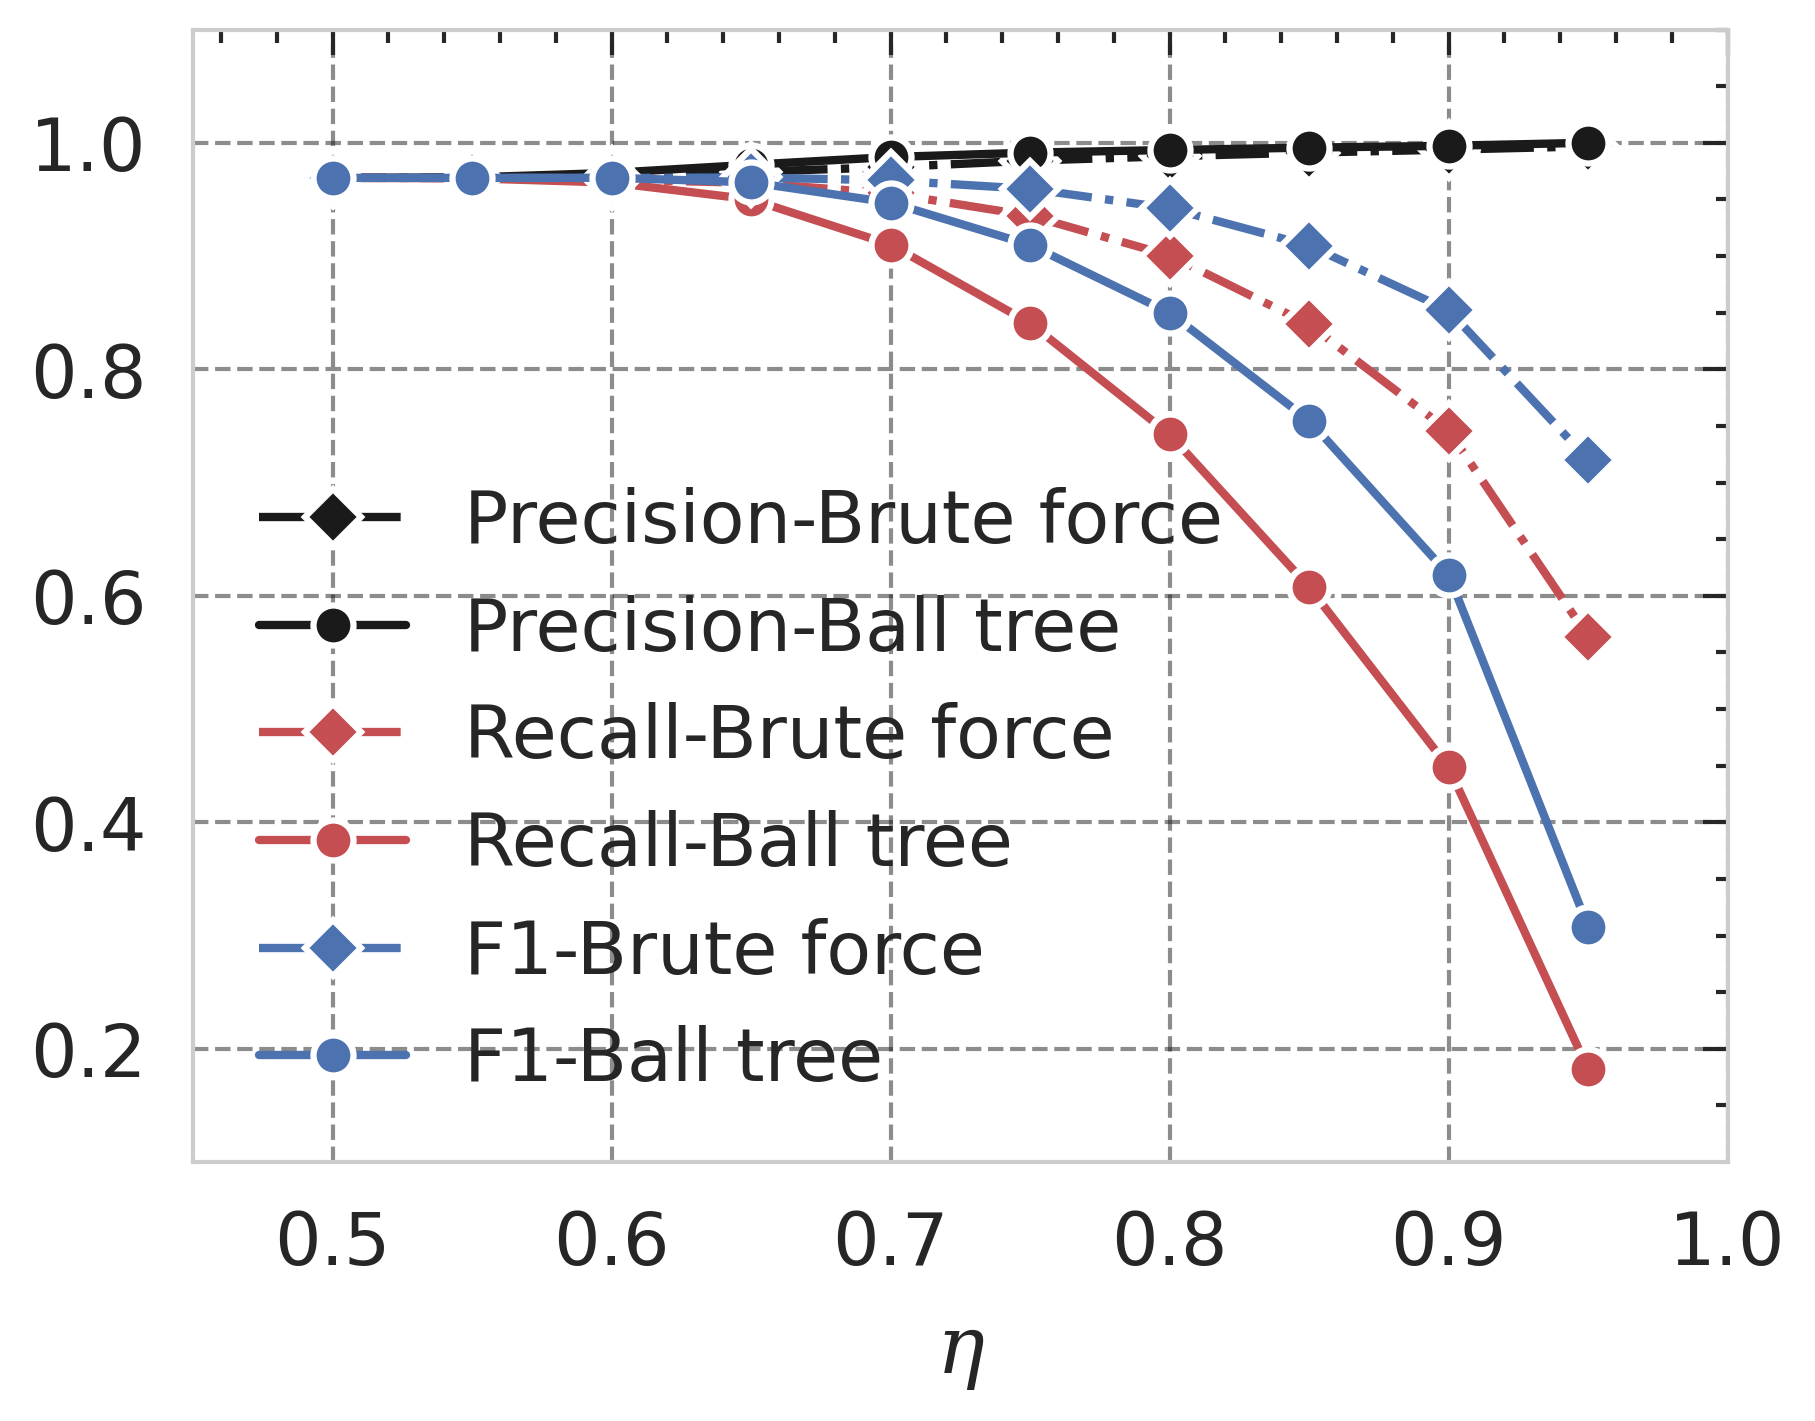

In [75]:
sns.set_palette(sns.color_palette("colorblind"))
plt.style.use(['science', 'ieee', 'no-latex'])
# sns.set_context("paper")

# plt.subplots(figsize=(5,4))
x = np.arange(start_threshold, end_threshold, step)
# sns.lineplot(x=x, y=brute_force_precision, label="Precision-Brute force", ls='--', marker='D')
# sns.lineplot(x=x, y=brute_force_recall, label="Recall-Brute force", ls='--', marker='D')
# sns.lineplot(x=x, y=brute_force_f1, label="F1-Brute force", ls='--', marker='D')
# sns.lineplot(x=x, y=ball_tree_precision, label="Precision-Ball tree", linestyle='-', marker="o")
# sns.lineplot(x=x, y=ball_tree_recall, label="Recall-Ball tree", linestyle='-', marker="o")
# sns.lineplot(x=x, y=ball_tree_f1, label="F1-Ball tree", linestyle='-', marker="o")
sns.lineplot(x=x, y=brute_force_precision, label="Precision-Brute force", ls='-.', marker='D', color="k")
sns.lineplot(x=x, y=ball_tree_precision, label="Precision-Ball tree", linestyle='-', marker="o", color="k")
sns.lineplot(x=x, y=brute_force_recall, label="Recall-Brute force", ls='-.', marker='D', color="r")
sns.lineplot(x=x, y=ball_tree_recall, label="Recall-Ball tree", linestyle='-', marker="o", color="r")
sns.lineplot(x=x, y=brute_force_f1, label="F1-Brute force", ls='-.', marker='D', color="b")
sns.lineplot(x=x, y=ball_tree_f1, label="F1-Ball tree", linestyle='-', marker="o", color="b")
plt.xlim(0.45, 1.0)
plt.ylim(0.1, 1.1)
plt.xlabel("$\eta$")
plt.savefig("figures/Linkage quatity analysis.pdf", dpi=300)

In [45]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'bright',
 'cjk-jp-font',
 'cjk-kr-font',
 'cjk-sc-font',
 'cjk-tc-font',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'grid',
 'high-contrast',
 'high-vis',
 'ieee',
 'latex-sans',
 'light',
 'muted',
 'nature',
 'no-latex',
 'notebook',
 'pgf',
 'retro',
 'scatter',
 'science',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'std-colors',
 'tableau-colorblind10',
 'vibrant']

## runtime analysis

In [32]:
def encrypt_tensor(tensor, public_key):
    encrypted_zero = public_key.encrypt(0)
    if isinstance(tensor, np.ndarray):
        return np.vectorize(lambda e: encrypted_zero + e)(tensor)
    else:
        raise NotImplementedError(f"type={type(tensor)}")

def decrypt_tensor(tensor, private_key, otypes):
    if isinstance(tensor, np.ndarray):
        return np.vectorize(private_key.decrypt, otypes)(tensor)
    else:
        raise NotImplementedError(f"type={type(tensor)}")

In [33]:
x = np.random.rand(1, 256).astype(object)
time_0 = time.time()
x_enc = encrypt_tensor(x, public_key)
vector_enc_time = time.time() - time_0

In [34]:
vector_enc_time

1.960442304611206

In [35]:
y = np.random.rand(1, 256).astype(object)
time_0 = time.time()
sim_enc = np.dot(x_enc, y.T)
sim_enc_cal_time = time.time() - time_0
sim_enc_cal_time

2.365262031555176

In [36]:
time_0 = time.time()
decrypt_tensor(sim_enc, private_key, [object])
sim_dec_time = time.time() - time_0
sim_dec_time

0.10722017288208008

In [37]:
def encrypt_tensor(tensor, public_key):
    return tensor

def decrypt_tensor(tensor, private_key, otypes):
    return tensor

### brute force

In [38]:
brute_force_runtime = D_s * D_r * (sim_enc_cal_time + sim_dec_time)
brute_force_runtime

123624110.2218628

### Ball tree

In [39]:
ball_tree_runtime = []
for cs_threshold in np.arange(start_threshold, end_threshold, step):
    cs_threshold = round(cs_threshold, 2)
    # matched pairs
    matches_ball_tree = []
    runtime = 0
    time_ball_start = time.time()
    for idx_a, query in enumerate(alice_representation_database):
        query = query.reshape(1, -1)
        # Alice: encrypt query vector
        query_enc = encrypt_tensor(query, public_key)
        # Alice: generate query ball
        noise = np.random.rand(*query.shape)
        rand_r = np.random.random_sample() * varepsilon
        noise = normalize(noise) * rand_r
        query_ball_c, query_ball_r = query + noise, 2 - 2 * cs_threshold + rand_r
        assert math.isclose(np.linalg.norm(query_ball_c-query), rand_r)

        # Bob: query ball in ball tree
        inds_ball_tree = ball_tree_bob.query_radius(query_ball_c, query_ball_r)
        inds_ball_tree = inds_ball_tree[0]
        if inds_ball_tree.size > 0:
            candidates_ball_tree = bob_representation_database[inds_ball_tree]
            # Bob: compute encryted similarities
            simsEnc_ball_tree = np.dot(candidates_ball_tree, query_enc.T)
            # Alice: decrypte similarities
            simsDec_ball_tree = decrypt_tensor(simsEnc_ball_tree, private_key, [object])
            runtime += (sim_enc_cal_time + sim_dec_time) * inds_ball_tree.size
            # Alice: select match pairs
            argmax_ball_tree = simsDec_ball_tree.argmax()
            simMax_ball_tree = simsDec_ball_tree[argmax_ball_tree]
            if simMax_ball_tree >= cs_threshold:
                indMax_ball_tree = inds_ball_tree[argmax_ball_tree]
                matches_ball_tree.append((idx_a, indMax_ball_tree))

    runtime += time.time() - time_ball_start
    ball_tree_runtime.append(runtime)
    print(f"cs_threshold {cs_threshold}: runtime={runtime}")

cs_threshold 0.5: runtime=276366.2645699978
cs_threshold 0.55: runtime=70501.63998699188
cs_threshold 0.6: runtime=25042.219822645187
cs_threshold 0.65: runtime=15100.344157457352
cs_threshold 0.7: runtime=12268.673121929169
cs_threshold 0.75: runtime=10773.86079788208
cs_threshold 0.8: runtime=9420.35799407959
cs_threshold 0.85: runtime=7550.409911632538
cs_threshold 0.9: runtime=5600.6022980213165
cs_threshold 0.95: runtime=2242.8942790031433


In [40]:
relative_runtime = brute_force_runtime / np.array(ball_tree_runtime)
relative_runtime

array([  447.31982905,  1753.49268818,  4936.62746743,  8186.84057349,
       10076.40426909, 11474.44843971, 13123.0798553 , 16373.16538688,
       22073.3599073 , 55118.11741604])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


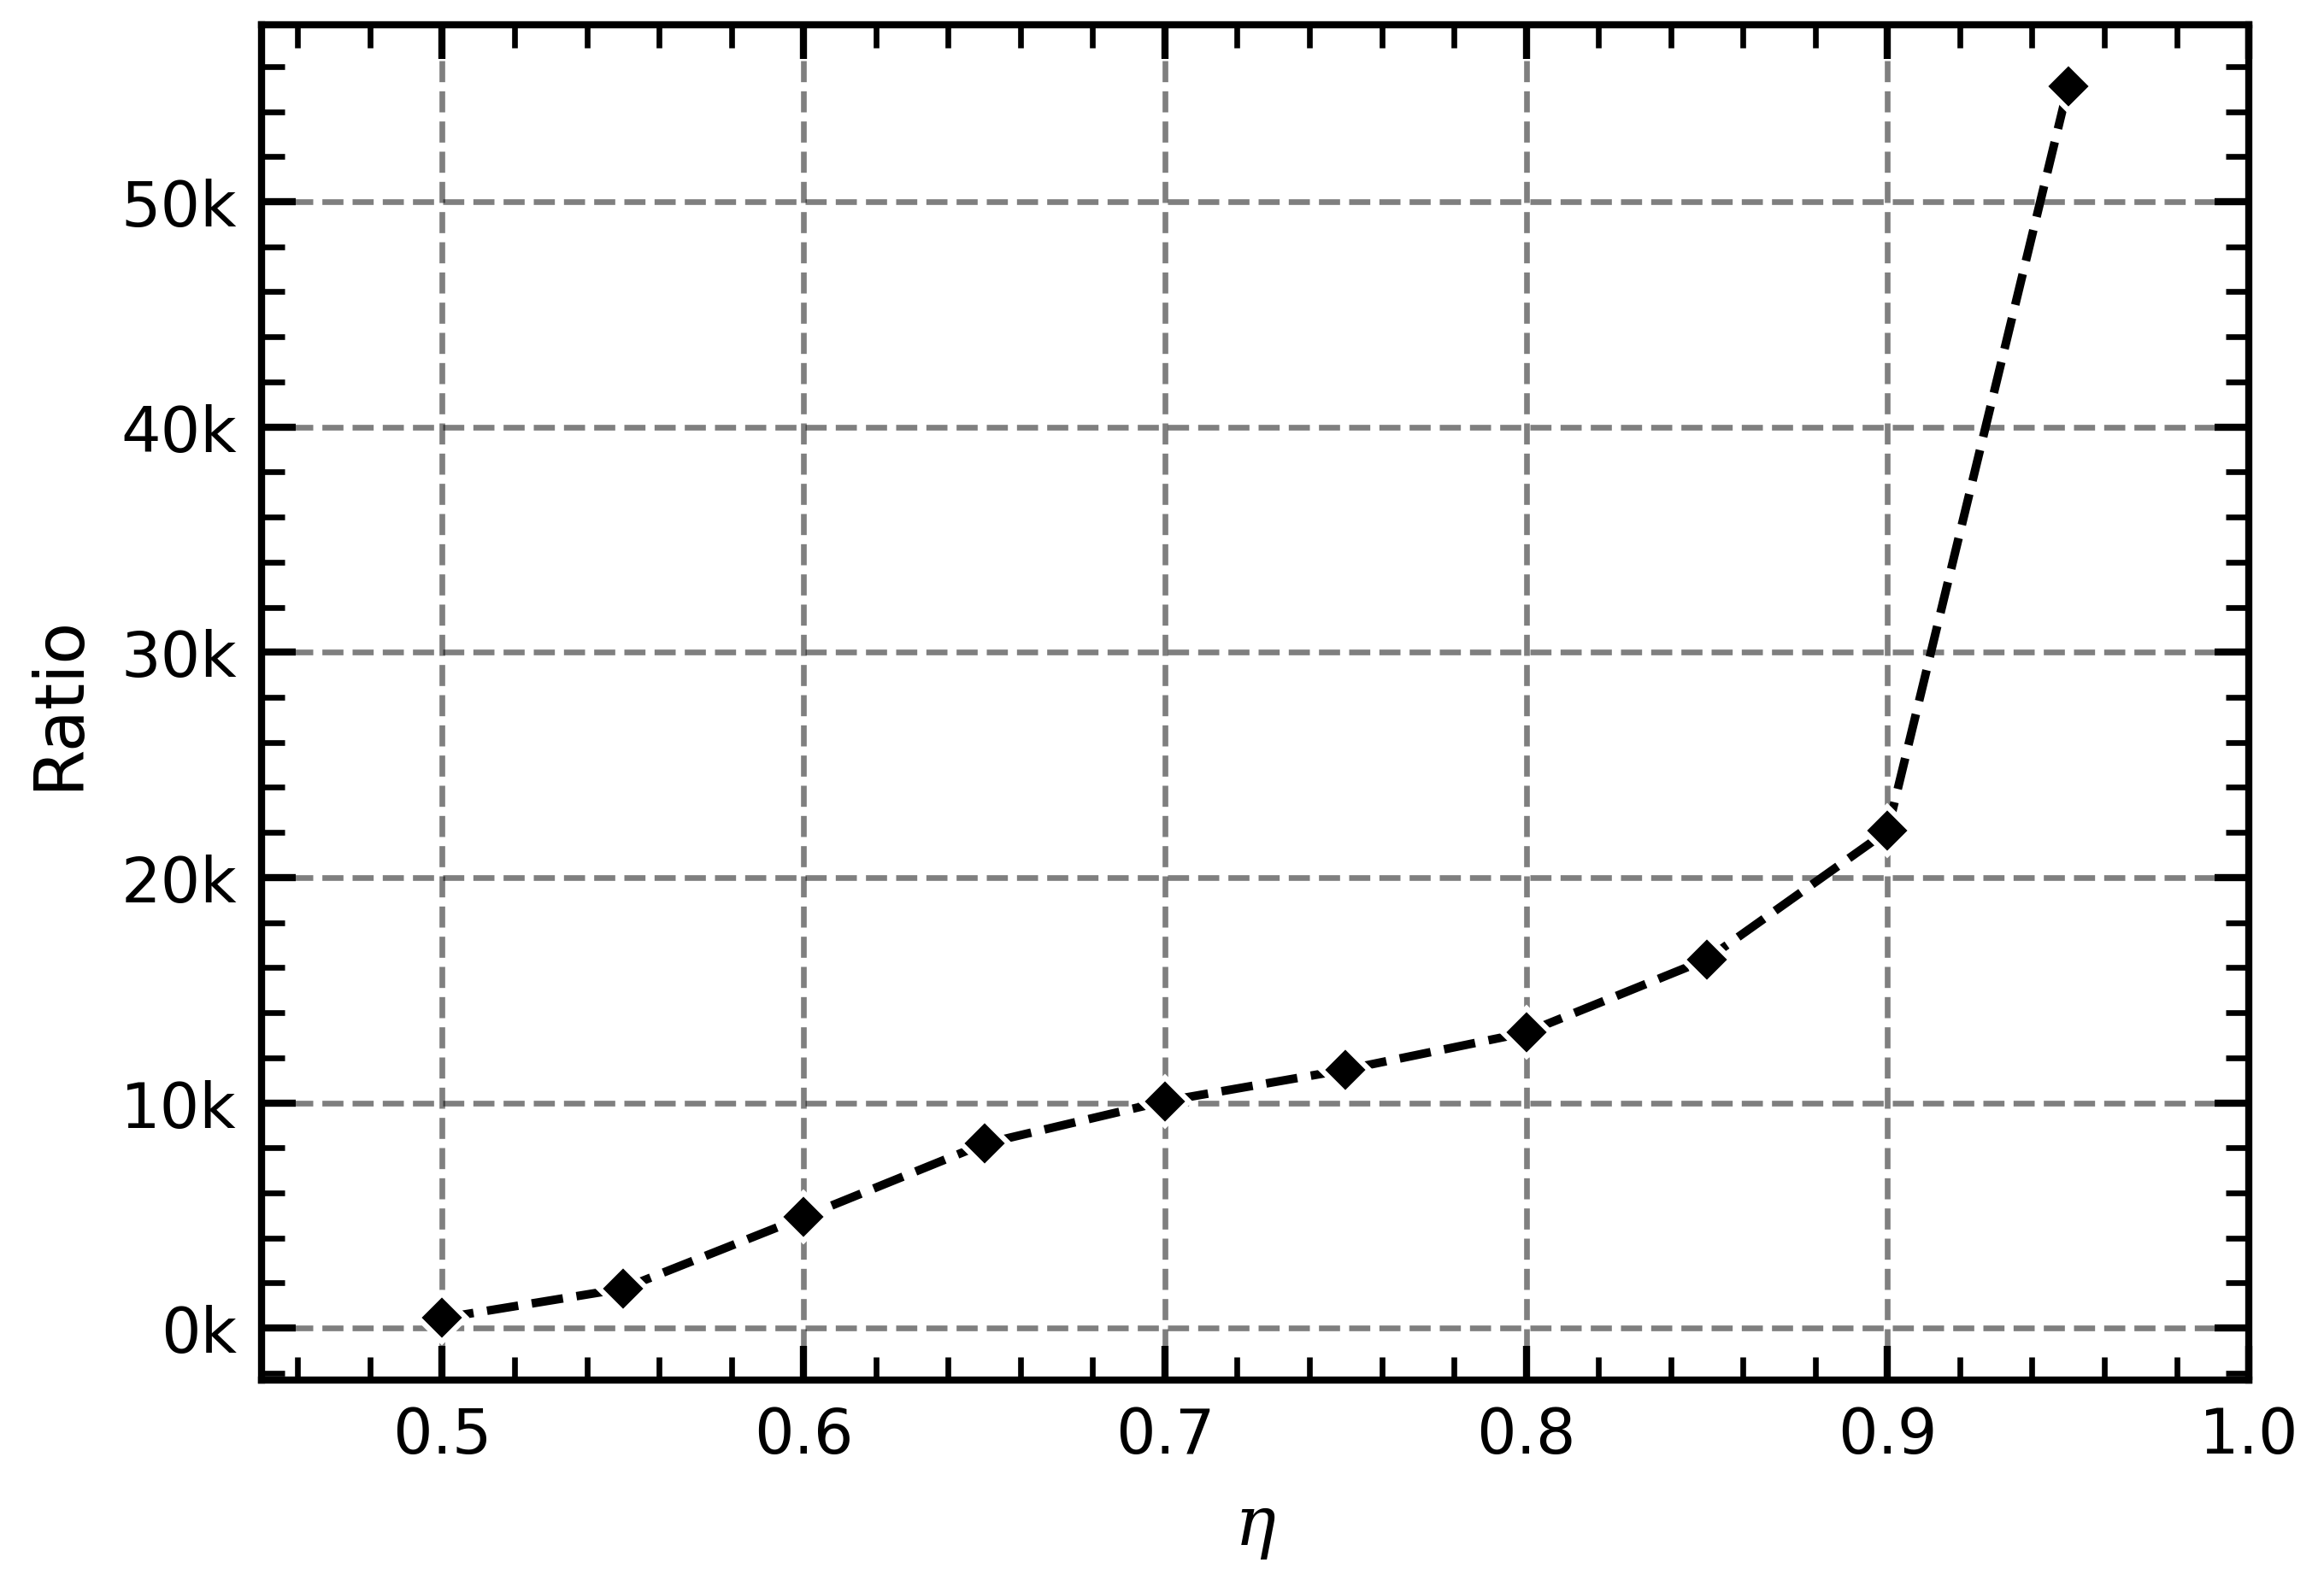

In [44]:
plt.style.use(['science', 'grid', 'no-latex'])
# sns.set(style="whitegrid")
# sns.set_palette(sns.color_palette("deep"))
sns.set_context("paper")
# sns.despine(right=False, top=True)

plt.subplots(figsize=(5,3.5))
x = np.arange(start_threshold, end_threshold, step)

g = sns.lineplot(x=x, y=relative_runtime, ls='--', marker='D', color='black')
ylabels = [str(int(y)) + 'k' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.xlim(0.45, 1.0)
plt.xlabel("$\eta$")
plt.ylabel("Ratio")
plt.savefig("figures/Runtime analysis.pdf", dpi=300)

In [ ]:
# Alice generate paillier keypair
public_key, private_key = paillier.generate_paillier_keypair()
# Bob construct ball tree
ball_tree_bob = BallTree(bob_representation_database)
# scope of noise \varepsilon
varepsilon = 0.1

# test threshold
start_threshold, end_threshold, step = 0.5, 1.0, 0.05
ball_tree_runtime = []
for cs_threshold in np.arange(start_threshold, end_threshold, step):
    cs_threshold = round(cs_threshold, 2)
    # matched pairs
    matches_ball_tree = []
    runtime = 0
    time_ball_start = time.time()
    for idx_a, query in enumerate(alice_representation_database):
        query = query.reshape(1, -1)
        # Alice: encrypt query vector
        query_enc = encrypt_tensor(query, public_key)
        runtime += sim_enc_cal_time
        # Alice: generate query ball
        noise = np.random.rand(*query.shape)
        rand_r = np.random.random_sample() * varepsilon
        noise = normalize(noise) * rand_r
        query_ball_c, query_ball_r = query + noise, 2 - 2 * cs_threshold + rand_r
        assert math.isclose(np.linalg.norm(query_ball_c-query), rand_r)

        # Bob: query ball in ball tree
        inds_ball_tree = ball_tree_bob.query_radius(query_ball_c, query_ball_r)
        inds_ball_tree = inds_ball_tree[0]
        if inds_ball_tree.size > 0:
            candidates_ball_tree = bob_representation_database[inds_ball_tree]
            # Bob: compute encryted similarities
            simsEnc_ball_tree = np.dot(candidates_ball_tree, query_enc.T)
            # Alice: decrypte similarities
            simsDec_ball_tree = decrypt_tensor(simsEnc_ball_tree, private_key, [object])
            runtime += (sim_enc_cal_time + sim_dec_time) * inds_ball_tree.size
            # Alice: select match pairs
            argmax_ball_tree = simsDec_ball_tree.argmax()
            simMax_ball_tree = simsDec_ball_tree[argmax_ball_tree]
            if simMax_ball_tree >= cs_threshold:
                indMax_ball_tree = inds_ball_tree[argmax_ball_tree]
                matches_ball_tree.append((idx_a, indMax_ball_tree))

    runtime += time.time() - time_ball_start
    ball_tree_runtime.append(runtime)
    print(f"cs_threshold {cs_threshold}: runtime={runtime}")